<a href="https://colab.research.google.com/github/youtlh/DeepLearningPytorch/blob/main/P1Ch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print(torch.__version__)

In [3]:
from torchvision import models

In [ ]:
# Check the existing pretrain model. Capital model are class from scratch, lowercase are model as function to be called with pretrain parameter.
dir(models)

# Image Classification

In [5]:
alexnet = models.AlexNet()

In [ ]:
resnet = models.resnet101(pretrained=True)

In [ ]:
# Check model structure
resnet

In [8]:
# image preprocessing pipeline, output is the img in tensor
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256), # resize model to 256 x 256
    transforms.CenterCrop(224), # crop image to 224 x 224 around the center
    transforms.ToTensor(), # 3D tensor with color, height, and width
    transforms.Normalize( # normalize the RGB components
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

In [32]:
# Load picture from github using pillow
# Convert the URL in two steps: 1. Change: /github.com/ to raw.githubusercontent.com 2. Remove "/blob/" from the URL
import requests
from io import BytesIO
from PIL import Image
url = 'https://raw.githubusercontent.com/deep-learning-with-pytorch/dlwpt-code/master/data/p1ch2/bobby.jpg'
page = requests.get(url)
img = Image.open(BytesIO(page.content))

In [10]:
img_t = preprocess(img)

In [11]:
import torch
batch_t = torch.unsqueeze(img_t, 0)

In [ ]:
resnet.eval()

In [ ]:
out = resnet(batch_t)
out

In [14]:
master = "https://raw.githubusercontent.com/deep-learning-with-pytorch/dlwpt-code/master/data/p1ch2/imagenet_classes.txt"
req = requests.get(master)
req = req.text
labels = req.split('\n')

In [15]:
# find the indices and value for the maximum value in tensor
_, index = torch.max(out, 1)

In [16]:
# normalize output to the range [0,1] and divide by sum
percentage = torch.nn.functional.softmax(out, dim=1)[0]*100
labels[index[0]], percentage[index[0]].item()

('golden retriever', 96.29335021972656)

In [17]:
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]] # find the top five

[('golden retriever', 96.29335021972656),
 ('Labrador retriever', 2.8081188201904297),
 ('cocker spaniel, English cocker spaniel, cocker', 0.2826734781265259),
 ('redbone', 0.2086300402879715),
 ('tennis ball', 0.11621593683958054)]

# Cycle GAN

In [18]:
import torch
import torch.nn as nn

In [19]:
class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out

In [20]:
class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [21]:
netG = ResNetGenerator() # using random weights

In [36]:
# download the weights of the model and load it. The weights are stored in the .pth pickle file.
url = 'https://raw.githubusercontent.com/deep-learning-with-pytorch/dlwpt-code/master/data/p1ch2/horse2zebra_0.4.0.pth'
page = requests.get(url)
model_data = torch.load(BytesIO(page.content))
netG.load_state_dict(model_data)

<All keys matched successfully>

In [ ]:
netG.eval()

In [38]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

In [39]:
url = 'https://raw.githubusercontent.com/deep-learning-with-pytorch/dlwpt-code/master/data/p1ch2/horse.jpg'
page = requests.get(url)
img = Image.open(BytesIO(page.content))

In [40]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

In [41]:
batch_out = netG(batch_t)

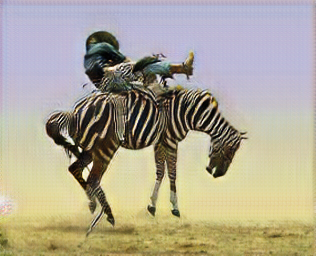

In [42]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img